In [2]:
import torch
import torch.optim as optim
import torchvision
from torchvision import transforms
import torch.nn.functional as F
import torchvision.transforms.functional as TF
import torch.nn as nn
# %cd /tf/detectron2
# import detectron2
# from detectron2.data.datasets import register_coco_instances
# from detectron2.data import MetadataCatalog
# from detectron2.data import DatasetCatalog
# from detectron2.data import transforms as T
# from detectron2.utils.logger import setup_logger
# setup_logger()
from PIL import Image, ImageDraw
from scipy.optimize import linear_sum_assignment
import torch.nn.functional as F
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import json
import copy
# from sklearn.metrics import precision_recall_fscore_support

In [3]:
# xmin, ymin, xmax, ymax to xmin, ymin, w, h
def xyxy_to_xywh(coordenadas, clamp=False):
    coordenadas = torch.stack((coordenadas[:, 0],
                               coordenadas[:, 1],
                               coordenadas[:, 2] - coordenadas[:, 0],
                               coordenadas[:, 3] - coordenadas[:, 1]
                               ), dim=1)
    if clamp:
        coordenadas = torch.clamp(coordenadas, min=0, max=1)
    return coordenadas

# xmin, ymin, w, h to xmin, ymin, xmax, ymax
def xywh_to_xyxy(coordenadas, clamp=False):
    coordenadas = torch.stack((coordenadas[:, 0], 
                               coordenadas[:, 1], 
                               coordenadas[:, 0] + coordenadas[:, 2],
                               coordenadas[:, 1] + coordenadas[:, 3]
                               ), dim=1)
    if clamp:
        coordenadas = torch.clamp(coordenadas, min=0, max=1)    
    return coordenadas

# cx, cy, w, h to xmin, ymin, xmax, ymax
def cxcywh_to_xyxy(coordenadas, clamp=False):
    coordenadas = torch.stack((coordenadas[:, 0] - coordenadas[:, 2] / 2,
                               coordenadas[:, 1] - coordenadas[:, 3] / 2,
                               coordenadas[:, 0] + coordenadas[:, 2] / 2,
                               coordenadas[:, 1] + coordenadas[:, 3] / 2
                               ), dim=1)
    if clamp:
        coordenadas = torch.clamp(coordenadas, min=0, max=1)    
    return coordenadas

# xmin, ymin, xmax, ymax to cx, cy, w, h
def xyxy_to_cxcywh(coordenadas, clamp=False):
    coordenadas = torch.stack(((coordenadas[:, 0] + coordenadas[:, 2]) / 2,
                               (coordenadas[:, 1] + coordenadas[:, 3]) / 2,
                               coordenadas[:, 2] - coordenadas[:, 0],
                               coordenadas[:, 3] - coordenadas[:, 1]
                               ), dim=1)
    if clamp:
        coordenadas = torch.clamp(coordenadas, min=0, max=1)    
    return coordenadas

# cx, cy, w, h to xmin, ymin, w, h
def cxcywh_to_xywh(coordenadas, clamp=False):
    coordenadas = torch.stack((coordenadas[:, 0] - coordenadas[:, 2] / 2,
                               coordenadas[:, 1] - coordenadas[:, 3] / 2,
                               coordenadas[:, 2],
                               coordenadas[:, 3]
                               ), dim=1)
    if clamp:
        coordenadas = torch.clamp(coordenadas, min=0, max=1)    
    return coordenadas

In [4]:
class PoolDetectionModel(nn.Module):
    def __init__(self, num_classes, num_predictions = 100):
        super(PoolDetectionModel, self).__init__()
        
        # Cargamos el modelo pre-entrenado
        self.model = torch.hub.load('facebookresearch/detr:main', 'detr_resnet50', pretrained=True)

        # Cambiamos el número de clases de salida
        hidden_dim = self.model.transformer.d_model
        self.model.num_classes = num_classes
        self.model.class_embed = nn.Linear(hidden_dim, num_classes)
        
        # Cambiamos el número predicciones
        if num_predictions != 100:
            num_query = self.model.transformer.d_model
            self.model.query_embed = nn.Embedding(num_predictions, num_query)
                
    def forward(self, x):
        # Pasamos las imágenes por el modelo pre-entrenado
        outputs = self.model(x)
        
        # Obtenemos las cajas y las etiquetas de las predicciones
        outputs['pred_logits'] = torch.sigmoid(outputs['pred_logits'])
        
        # Devolvemos las cajas y las etiquetas
        return outputs

In [40]:
path = 'C:\\Users\\rober\\Downloads\\'
path_image = path + 'Captura_3.JPG'
path_model = path + 'model_192.pt'

In [20]:
model = PoolDetectionModel(num_classes=1)
model = torch.load(path_model, map_location=torch.device('cpu'))
model.eval();

Using cache found in C:\Users\rober/.cache\torch\hub\facebookresearch_detr_main


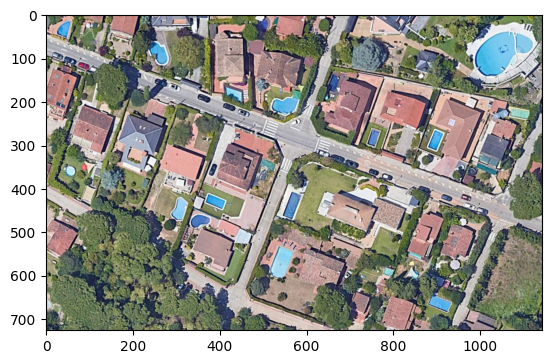

In [54]:
new_size = (600, 600)
resize = transforms.Resize(new_size, antialias=None)
normalize = transforms.Normalize(mean=[0.53016539, 0.48067732, 0.410102], std=[0.25151319, 0.2374013, 0.23417556])
transform = transforms.Compose([transforms.ToTensor(), resize, normalize])
# Define the normalization transform
image_original = Image.open(path_image)
width, height = image_original.size
# Show the image
fig, ax = plt.subplots()
ax.imshow(image_original)
plt.show()

4


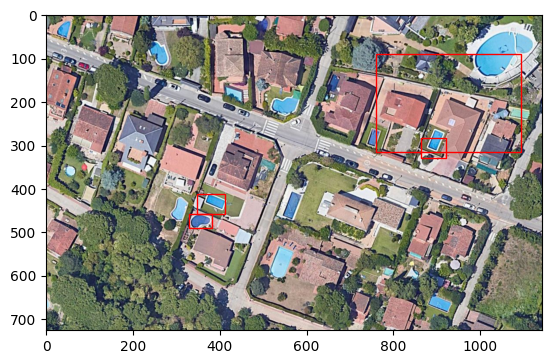

In [56]:
threshold = 0.5
image = transform(image_original).unsqueeze(0)
output = model(image)
n = 0
image = image.cpu().numpy()
image = np.moveaxis(image, 0, -1)
mask = output["pred_logits"][n] > threshold
mask = torch.cat((mask, mask, mask, mask), 1)
pred_boxes = cxcywh_to_xywh(output["pred_boxes"][n][mask].reshape(-1, 4))
if pred_boxes.shape[0] > 0:
    fig, ax = plt.subplots()
    print(pred_boxes.shape[0])
    for bounding_box in pred_boxes:
        x, y, w, h = bounding_box.cpu().detach().numpy()
        x, y, w, h = x*width, y*height, w*width, h*height
        bb = patches.Rectangle((x, y), w, h, linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(bb)
    ax.imshow(image_original)
    plt.show()